c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10, Train Loss: 0.3323, Val Loss: 0.3303
Epoch 2/10, Train Loss: 0.2839, Val Loss: 0.2864
Epoch 3/10, Train Loss: 0.2506, Val Loss: 0.2576
Epoch 4/10, Train Loss: 0.2197, Val Loss: 0.2302
Epoch 5/10, Train Loss: 0.1935, Val Loss: 0.2068
Epoch 6/10, Train Loss: 0.1721, Val Loss: 0.1877
Epoch 7/10, Train Loss: 0.1545, Val Loss: 0.1721
Epoch 8/10, Train Loss: 0.1399, Val Loss: 0.1594
Epoch 9/10, Train Loss: 0.1276, Val Loss: 0.1490
Epoch 10/10, Train Loss: 0.1170, Val Loss: 0.1404

Test Accuracy: 0.9617


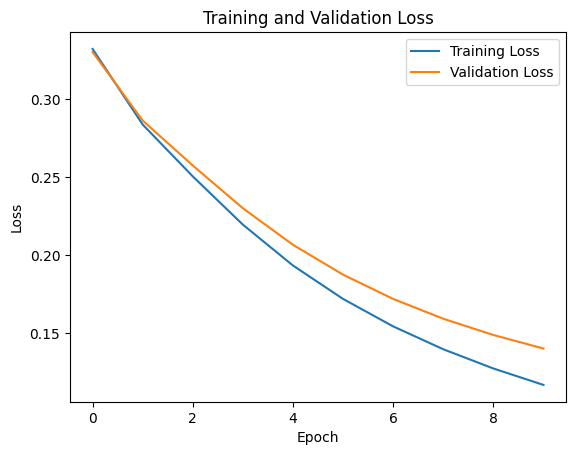

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt

class ScratchSimpleNeuralNetworkClassifier():
    """
    Simple three-layer neural network classifier
    
    Parameters
    ----------
    n_nodes1 : int (default=400)
        Number of nodes in first hidden layer
    n_output : int (default=10)
        Number of output nodes
    sigma : float (default=0.01)
        Standard deviation for weight initialization
    epochs : int (default=10)
        Number of epochs to train
    batch_size : int (default=20)
        Mini-batch size
    lr : float (default=0.01)
        Learning rate
    verbose : bool (default=True)
        Whether to print progress during training
        
    Attributes
    ----------
    loss_train : list
        Training loss for each epoch
    loss_val : list
        Validation loss for each epoch
    """
    
    def __init__(self, n_nodes1=400, n_output=10, sigma=0.01, 
                 epochs=10, batch_size=20, lr=0.01, verbose=True):
        self.n_nodes1 = n_nodes1
        self.n_output = n_output
        self.sigma = sigma
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.verbose = verbose
        self.loss_train = []
        self.loss_val = []
        
    def _init_weights(self, n_features):
        """Initialize weights and biases"""
        # Layer 1 weights 
        self.W1 = self.sigma * np.random.randn(n_features, self.n_nodes1)
        self.b1 = np.zeros(self.n_nodes1)
        
        # Layer 2 weights
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_output)
        self.b2 = np.zeros(self.n_output)
    
    def _sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))
    
    def _softmax(self, x):
        """Softmax function"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def _cross_entropy_loss(self, y_pred, y_true):
        """Cross entropy loss"""
        delta = 1e-7  # to avoid log(0)
        return -np.sum(y_true * np.log(y_pred + delta)) / len(y_pred)
    
    def _forward_propagation(self, X):
        """Forward propagation"""
        # Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._sigmoid(self.z1)
        
        # Layer 2 
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._softmax(self.z2)
        
        return self.a2
    
    def _backward_propagation(self, X, y, y_pred):
        """Backward propagation"""
        m = len(X)  # batch size
        
        # Layer 2 gradients
        dz2 = (y_pred - y) / m
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0)
        
        # Layer 1 gradients
        dz1 = np.dot(dz2, self.W2.T) * (self.a1 * (1 - self.a1))
        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0)
        
        return dW1, db1, dW2, db2
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Features of training data
        y : ndarray, shape (n_samples, n_classes)
            Correct answer value of training data (one-hot encoded)
        X_val : ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : ndarray, shape (n_samples, n_classes)
            Correct value of verification data (one-hot encoded)
        """
        n_features = X.shape[1]
        self._init_weights(n_features)
        
        for epoch in range(self.epochs):
            # Mini-batch training
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            
            for mini_X, mini_y in get_mini_batch:
                # Forward propagation
                y_pred = self._forward_propagation(mini_X)
                
                # Backward propagation
                dW1, db1, dW2, db2 = self._backward_propagation(mini_X, mini_y, y_pred)
                
                # Update parameters
                self.W1 -= self.lr * dW1
                self.b1 -= self.lr * db1
                self.W2 -= self.lr * dW2
                self.b2 -= self.lr * db2
            
            # Calculate loss after each epoch
            train_pred = self._forward_propagation(X)
            train_loss = self._cross_entropy_loss(train_pred, y)
            self.loss_train.append(train_loss)
            
            if X_val is not None and y_val is not None:
                val_pred = self._forward_propagation(X_val)
                val_loss = self._cross_entropy_loss(val_pred, y_val)
                self.loss_val.append(val_loss)
            
            if self.verbose:
                if X_val is not None and y_val is not None:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}")
    
    def predict(self, X):
        """
        Estimate using a neural network classifier.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            sample
            
        Returns
        -------
        ndarray, shape (n_samples, n_classes)
            Estimated probabilities for each class
        """
        return self._forward_propagation(X)
    
    def predict_class(self, X):
        """
        Predict class labels
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            sample
            
        Returns
        -------
        ndarray, shape (n_samples,)
            Predicted class labels
        """
        proba = self.predict(X)
        return np.argmax(proba, axis=1)

class GetMiniBatch:
    """
    Iterator to get a mini-batch
    
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Training data
    y : ndarray, shape (n_samples, n_classes)
        Correct answer value
    batch_size : int
        Batch size
    seed : int
        NumPy random seed
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)  # Changed from np.int to int
    
    def __len__(self):
        return self._stop
    
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# Load  MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten images 
X_train = X_train.reshape(-1, 784).astype(np.float64)  
X_test = X_test.reshape(-1, 784).astype(np.float64)    

# Normalize pixel values
X_train /= 255
X_test /= 255

# One-hot encode labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train_one_hot, test_size=0.2, random_state=42)

# Train the neural network
nn = ScratchSimpleNeuralNetworkClassifier(
    n_nodes1=400, 
    sigma=0.01, 
    epochs=10, 
    batch_size=20, 
    lr=0.1, 
    verbose=True
)
nn.fit(X_train, y_train, X_val, y_val)

# Evaluate on test set
test_pred = nn.predict_class(X_test)
accuracy = np.mean(test_pred == y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Plot training and validation loss
plt.plot(nn.loss_train, label='Training Loss')
plt.plot(nn.loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np

class ThreeLayerNeuralNetwork:
    def __init__(self, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 activation='sigmoid', sigma=0.01):
        """
        Initialize a three-layer neural network
        
        Parameters:
        -----------
        n_features : int
            Number of input features (784 for MNIST)
        n_nodes1 : int
            Number of nodes in first hidden layer
        n_nodes2 : int
            Number of nodes in second hidden layer
        n_output : int
            Number of output nodes
        activation : str
            Activation function type ('sigmoid' or 'tanh')
        sigma : float
            Standard deviation for weight initialization
        """
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.activation_type = activation
        self.sigma = sigma
        
        # weights and biases
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights and biases with Gaussian distribution"""
        # Layer 1 weights 
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.B1 = np.zeros(self.n_nodes1)
        
        # Layer 2 weights 
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = np.zeros(self.n_nodes2)
        
        # Layer 3 weights 
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B3 = np.zeros(self.n_output)
    
    def _activation(self, A):
        """Apply activation function"""
        if self.activation_type == 'sigmoid':
            return 1 / (1 + np.exp(-A))
        elif self.activation_type == 'tanh':
            return np.tanh(A)
        else:
            raise ValueError("Activation must be 'sigmoid' or 'tanh'")
    
    def _softmax(self, A):
        """Softmax function for output layer"""
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))  # for numerical stability
        return exp_A / np.sum(exp_A, axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        """
        Perform forward propagation through the network
        
        Parameters:
        -----------
        X : ndarray, shape (batch_size, n_features)
            Input data (batch)
            
        Returns:
        --------
        Z3 : ndarray, shape (batch_size, n_output)
            Output probabilities
        """
        # First layer
        A1 = np.dot(X, self.W1) + self.B1
        Z1 = self._activation(A1)
        
        # Second layer
        A2 = np.dot(Z1, self.W2) + self.B2
        Z2 = self._activation(A2)
        
        # Output layer
        A3 = np.dot(Z2, self.W3) + self.B3
        Z3 = self._softmax(A3)
        
        # Store intermediate values for backpropagation
        self.A1, self.Z1 = A1, Z1
        self.A2, self.Z2 = A2, Z2
        self.A3, self.Z3 = A3, Z3
        
        return Z3

# 
if __name__ == "__main__":
    # Network parameters
    batch_size = 20
    n_features = 784
    n_nodes1 = 400
    n_nodes2 = 200
    n_output = 10
    
    # network instance
    nn = ThreeLayerNeuralNetwork(n_features=n_features, 
                                n_nodes1=n_nodes1,
                                n_nodes2=n_nodes2,
                                n_output=n_output,
                                activation='sigmoid')
    
    #dummy input data (batch_size=20, n_features=784)
    X_dummy = np.random.randn(batch_size, n_features)
    
    # Perform forward propagation
    output_probs = nn.forward_propagation(X_dummy)
    
    print("Input shape:", X_dummy.shape)
    print("Layer 1 weights shape:", nn.W1.shape)
    print("Layer 2 weights shape:", nn.W2.shape)
    print("Layer 3 weights shape:", nn.W3.shape)
    print("Output probabilities shape:", output_probs.shape)
    print("Sample output probabilities (first sample):", output_probs[0])
    print("Sum of probabilities (should be 1):", np.sum(output_probs[0]))

Input shape: (20, 784)
Layer 1 weights shape: (784, 400)
Layer 2 weights shape: (400, 200)
Layer 3 weights shape: (200, 10)
Output probabilities shape: (20, 10)
Sample output probabilities (first sample): [0.09637216 0.09392558 0.09780766 0.10503031 0.0991629  0.103421
 0.10910723 0.09800201 0.10439262 0.09277854]
Sum of probabilities (should be 1): 1.0


In [ ]:
import numpy as np

class NeuralNetworkWithCrossEntropy:
    def __init__(self, n_features=784, n_nodes1=400, n_output=10, sigma=0.01):
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_output = n_output
        self.sigma = sigma
        
        # Initialize weights
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.b1 = np.zeros(self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_output)
        self.b2 = np.zeros(self.n_output)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def _cross_entropy_error(self, y_pred, y_true):
        """
        Calculate cross-entropy error with numerical stability
        
        Parameters:
        -----------
        y_pred : ndarray (batch_size, n_classes)
            Predicted probabilities from softmax
        y_true : ndarray (batch_size, n_classes)
            True labels in one-hot encoding
            
        Returns:
        --------
        float : Cross-entropy error
        """
        delta = 1e-7  # Small value to prevent log(0)
        batch_size = y_pred.shape[0]
        
        # Calculate error for each sample and average
        error = -np.sum(y_true * np.log(y_pred + delta)) / batch_size
        return error
    
    def forward_propagation(self, X):
        """Forward pass through the network"""
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._softmax(self.z2)
        return self.a2
    
    def train(self, X, y, learning_rate=0.1, epochs=10, batch_size=20):
        """Train the network using mini-batch gradient descent"""
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(0, n_samples, batch_size):
                # Get mini-batch
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Forward pass
                y_pred = self.forward_propagation(X_batch)
                
                # Backward pass
                dz2 = (y_pred - y_batch) / batch_size
                dW2 = np.dot(self.a1.T, dz2)
                db2 = np.sum(dz2, axis=0)
                
                dz1 = np.dot(dz2, self.W2.T) * (self.a1 * (1 - self.a1))
                dW1 = np.dot(X_batch.T, dz1)
                db1 = np.sum(dz1, axis=0)
                
                # Update weights
                self.W1 -= learning_rate * dW1
                self.b1 -= learning_rate * db1
                self.W2 -= learning_rate * dW2
                self.b2 -= learning_rate * db2
            
            # Calculate and print loss
            y_pred_all = self.forward_propagation(X)
            loss = self._cross_entropy_error(y_pred_all, y)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

# MNIST data
if __name__ == "__main__":
    from keras.datasets import mnist
    from sklearn.preprocessing import OneHotEncoder
    
    #
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(-1, 784).astype(np.float64) / 255
    X_test = X_test.reshape(-1, 784).astype(np.float64) / 255
    
    # One-hot encode labels
    enc = OneHotEncoder(sparse=False)
    y_train_onehot = enc.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = enc.transform(y_test.reshape(-1, 1))
    
    # Create and train network
    nn = NeuralNetworkWithCrossEntropy(n_features=784, n_nodes1=400, n_output=10)
    nn.train(X_train, y_train_onehot, learning_rate=0.1, epochs=10, batch_size=20)
    
    # Evaluate on test set
    test_pred = nn.forward_propagation(X_test)
    test_pred_classes = np.argmax(test_pred, axis=1)
    accuracy = np.mean(test_pred_classes == y_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")

c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10, Loss: 0.3316
Epoch 2/10, Loss: 0.2764
Epoch 3/10, Loss: 0.2276
Epoch 4/10, Loss: 0.1957
Epoch 5/10, Loss: 0.1696
Epoch 6/10, Loss: 0.1471
Epoch 7/10, Loss: 0.1324
Epoch 8/10, Loss: 0.1177
Epoch 9/10, Loss: 0.1100
Epoch 10/10, Loss: 0.0976

Test Accuracy: 0.9673


In [ ]:
import numpy as np

class ThreeLayerNeuralNetwork:
    def __init__(self, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 sigma=0.01, learning_rate=0.1):
        """
        Initialize a three-layer neural network
        
        Parameters:
        -----------
        n_features : int
            Number of input features (784 for MNIST)
        n_nodes1 : int
            Number of nodes in first hidden layer
        n_nodes2 : int
            Number of nodes in second hidden layer
        n_output : int
            Number of output nodes
        sigma : float
            Standard deviation for weight initialization
        learning_rate : float
            Learning rate for gradient descent
        """
        # Network architecture
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.learning_rate = learning_rate
        
        # Initialize weights and biases
        self._init_weights(sigma)
        
    def _init_weights(self, sigma):
        """Initialize weights and biases with Gaussian distribution"""
        # Layer 1
        self.W1 = sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.B1 = np.zeros(self.n_nodes1)
        
        # Layer 2
        self.W2 = sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = np.zeros(self.n_nodes2)
        
        # Layer 3
        self.W3 = sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B3 = np.zeros(self.n_output)
    
    def _sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)
    
    def _softmax(self, x):
        """Softmax function for output layer"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def _cross_entropy_loss(self, y_pred, y_true):
        """Cross entropy loss with numerical stability"""
        delta = 1e-7  # to avoid log(0)
        batch_size = y_pred.shape[0]
        return -np.sum(y_true * np.log(y_pred + delta)) / batch_size
    
    def forward_propagation(self, X):
        """Forward pass through the network"""
        # Layer 1
        self.A1 = np.dot(X, self.W1) + self.B1
        self.Z1 = self._sigmoid(self.A1)
        
        # Layer 2
        self.A2 = np.dot(self.Z1, self.W2) + self.B2
        self.Z2 = self._sigmoid(self.A2)
        
        # Output layer
        self.A3 = np.dot(self.Z2, self.W3) + self.B3
        self.Z3 = self._softmax(self.A3)
        
        return self.Z3
    
    def backward_propagation(self, X, y_true, y_pred):
        """
        Backward propagation to compute gradients
        
        Parameters:
        -----------
        X : ndarray (batch_size, n_features)
            Input data
        y_true : ndarray (batch_size, n_output)
            True labels (one-hot encoded)
        y_pred : ndarray (batch_size, n_output)
            Predicted probabilities
        """
        batch_size = X.shape[0]
        
        # Third layer gradients
        dA3 = (y_pred - y_true) / batch_size  # ∂L/∂A3
        self.dB3 = np.sum(dA3, axis=0)        # ∂L/∂B3
        self.dW3 = np.dot(self.Z2.T, dA3)     # ∂L/∂W3
        dZ2 = np.dot(dA3, self.W3.T)          # ∂L/∂Z2
        
        # Second layer gradients
        dA2 = dZ2 * self._sigmoid_derivative(self.Z2)  # ∂L/∂A2
        self.dB2 = np.sum(dA2, axis=0)        # ∂L/∂B2
        self.dW2 = np.dot(self.Z1.T, dA2)     # ∂L/∂W2
        dZ1 = np.dot(dA2, self.W2.T)          # ∂L/∂Z1
        
        # First layer gradients
        dA1 = dZ1 * self._sigmoid_derivative(self.Z1)  # ∂L/∂A1
        self.dB1 = np.sum(dA1, axis=0)        # ∂L/∂B1
        self.dW1 = np.dot(X.T, dA1)           # ∂L/∂W1
    
    def update_weights(self):
        """Update weights using gradient descent"""
        self.W1 -= self.learning_rate * self.dW1
        self.B1 -= self.learning_rate * self.dB1
        self.W2 -= self.learning_rate * self.dW2
        self.B2 -= self.learning_rate * self.dB2
        self.W3 -= self.learning_rate * self.dW3
        self.B3 -= self.learning_rate * self.dB3
    
    def train(self, X_train, y_train, X_val=None, y_val=None, 
              epochs=10, batch_size=20, verbose=True):
        """
        Train the neural network
        
        Parameters:
        -----------
        X_train : ndarray (n_samples, n_features)
            Training data
        y_train : ndarray (n_samples, n_output)
            Training labels (one-hot encoded)
        X_val : ndarray (n_val_samples, n_features)
            Validation data
        y_val : ndarray (n_val_samples, n_output)
            Validation labels
        epochs : int
            Number of training epochs
        batch_size : int
            Size of mini-batches
        verbose : bool
            Whether to print training progress
        """
        n_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Mini-batch training
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Forward and backward pass
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, y_batch, y_pred)
                self.update_weights()
            
            # training loss
            train_pred = self.forward_propagation(X_train)
            train_loss = self._cross_entropy_loss(train_pred, y_train)
            
            if verbose:
                if X_val is not None and y_val is not None:
                    val_pred = self.forward_propagation(X_val)
                    val_loss = self._cross_entropy_loss(val_pred, y_val)
                    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")
    
    def predict(self, X):
        """Predict class probabilities"""
        return self.forward_propagation(X)
    
    def predict_classes(self, X):
        """Predict class labels"""
        proba = self.predict(X)
        return np.argmax(proba, axis=1)

In [ ]:
import numpy as np

class NeuralNetworkWithPrediction:
    def __init__(self, n_features=784, n_nodes1=400, n_output=10, sigma=0.01, learning_rate=0.1):
        """
        Initialize the neural network
        
        Parameters:
        -----------
        n_features : int
            Number of input features (784 for MNIST)
        n_nodes1 : int
            Number of nodes in hidden layer
        n_output : int
            Number of output classes
        sigma : float
            Standard deviation for weight initialization
        learning_rate : float
            Learning rate for gradient descent
        """
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_output = n_output
        self.sigma = sigma
        self.learning_rate = learning_rate
        
        # Initialize weights
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.b1 = np.zeros(self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_output)
        self.b2 = np.zeros(self.n_output)
    
    def _sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)
    
    def _softmax(self, x):
        """Softmax function"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        """Forward pass through the network"""
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._softmax(self.z2)
        return self.a2
    
    def predict(self, X):
        """Return class probabilities"""
        return self.forward_propagation(X)
    
    def predict_classes(self, X):
        """Return predicted class labels"""
        probabilities = self.predict(X)
        return np.argmax(probabilities, axis=1)

#MNIST
if __name__ == "__main__":
    from keras.datasets import mnist
    from sklearn.preprocessing import OneHotEncoder
    
    # 
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # 
    X_train = X_train.reshape(-1, 784).astype(np.float64) / 255
    X_test = X_test.reshape(-1, 784).astype(np.float64) / 255
    
    # One-hot encode labels
    enc = OneHotEncoder(sparse=False)
    y_train_onehot = enc.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = enc.transform(y_test.reshape(-1, 1))
    
    #network
    nn = NeuralNetworkWithPrediction(n_features=784, n_nodes1=400, n_output=10)
    
    #prediction before training
    sample = X_test[0:1]  # Take first test sample
    print("Sample shape:", sample.shape)
    print("Predicted probabilities:", nn.predict(sample))
    print("Predicted class:", nn.predict_classes(sample))
    print("True class:", y_test[0])

Sample shape: (1, 784)
Predicted probabilities: [[0.10794489 0.09386788 0.10126501 0.08577122 0.08621493 0.09997257
  0.10545238 0.10771176 0.0935364  0.11826296]]
Predicted class: [9]
True class: 7


c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10, Train Loss: 0.3317, Val Loss: 0.3300
Epoch 2/10, Train Loss: 0.2831, Val Loss: 0.2860
Epoch 3/10, Train Loss: 0.2500, Val Loss: 0.2573
Epoch 4/10, Train Loss: 0.2194, Val Loss: 0.2300
Epoch 5/10, Train Loss: 0.1936, Val Loss: 0.2068
Epoch 6/10, Train Loss: 0.1726, Val Loss: 0.1879
Epoch 7/10, Train Loss: 0.1553, Val Loss: 0.1724
Epoch 8/10, Train Loss: 0.1408, Val Loss: 0.1596
Epoch 9/10, Train Loss: 0.1284, Val Loss: 0.1489
Epoch 10/10, Train Loss: 0.1178, Val Loss: 0.1399

Test Accuracy: 0.9594


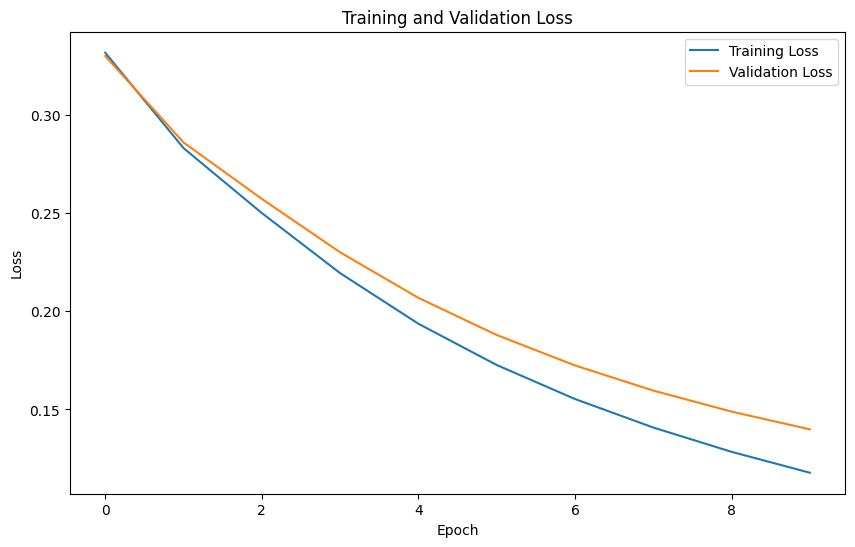

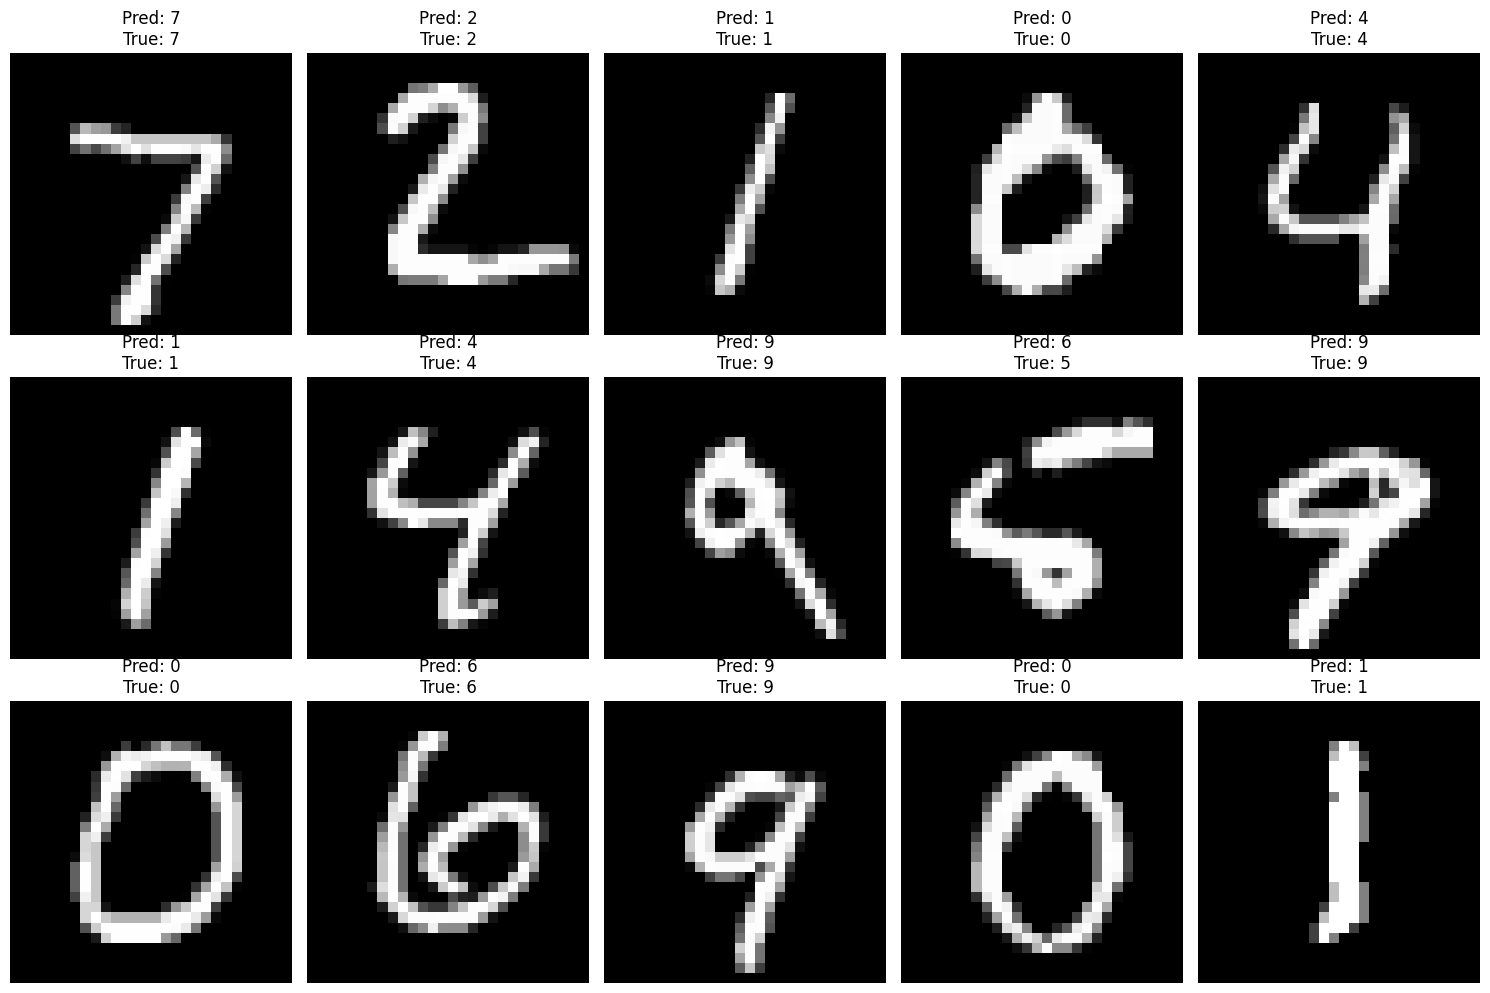

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt

class ScratchSimpleNeuralNetworkClassifier():
    def __init__(self, n_nodes1=400, n_output=10, sigma=0.01, 
                 epochs=10, batch_size=20, lr=0.1, verbose=True):
        self.n_nodes1 = n_nodes1
        self.n_output = n_output
        self.sigma = sigma
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.verbose = verbose
        self.loss_train = []
        self.loss_val = []
        
    def _init_weights(self, n_features):
        self.W1 = self.sigma * np.random.randn(n_features, self.n_nodes1)
        self.b1 = np.zeros(self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_output)
        self.b2 = np.zeros(self.n_output)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def _cross_entropy_loss(self, y_pred, y_true):
        delta = 1e-7
        return -np.sum(y_true * np.log(y_pred + delta)) / len(y_pred)
    
    def _forward_propagation(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._softmax(self.z2)
        return self.a2
    
    def _backward_propagation(self, X, y, y_pred):
        m = len(X)
        dz2 = (y_pred - y) / m
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0)
        dz1 = np.dot(dz2, self.W2.T) * (self.a1 * (1 - self.a1))
        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0)
        return dW1, db1, dW2, db2
    
    def fit(self, X, y, X_val=None, y_val=None):
        n_features = X.shape[1]
        self._init_weights(n_features)
        
        for epoch in range(self.epochs):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            
            for mini_X, mini_y in get_mini_batch:
                y_pred = self._forward_propagation(mini_X)
                dW1, db1, dW2, db2 = self._backward_propagation(mini_X, mini_y, y_pred)
                self.W1 -= self.lr * dW1
                self.b1 -= self.lr * db1
                self.W2 -= self.lr * dW2
                self.b2 -= self.lr * db2
            
            train_pred = self._forward_propagation(X)
            train_loss = self._cross_entropy_loss(train_pred, y)
            self.loss_train.append(train_loss)
            
            if X_val is not None and y_val is not None:
                val_pred = self._forward_propagation(X_val)
                val_loss = self._cross_entropy_loss(val_pred, y_val)
                self.loss_val.append(val_loss)
            
            if self.verbose:
                if X_val is not None and y_val is not None:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}")
    
    def predict(self, X):
        return self._forward_propagation(X)
    
    def predict_classes(self, X):
        return np.argmax(self.predict(X), axis=1)

class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    
    def __len__(self):
        return self._stop
    
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

#  MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784).astype(np.float64) / 255
X_test = X_test.reshape(-1, 784).astype(np.float64) / 255

# One-hot encode labels
enc = OneHotEncoder(sparse=False)
y_train_onehot = enc.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = enc.transform(y_test.reshape(-1, 1))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=42)

# Create and train network
nn = ScratchSimpleNeuralNetworkClassifier(
    n_nodes1=400, 
    sigma=0.01, 
    epochs=10, 
    batch_size=20, 
    lr=0.1, 
    verbose=True
)
nn.fit(X_train, y_train, X_val, y_val)

# Evaluate on test set
test_pred = nn.predict_classes(X_test)
accuracy = np.mean(test_pred == y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(nn.loss_train, label='Training Loss')
plt.plot(nn.loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# predictions
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    pred = test_pred[i]
    true = y_test[i]
    ax.set_title(f"Pred: {pred}\nTrue: {true}")
    ax.axis('off')
plt.tight_layout()
plt.show()

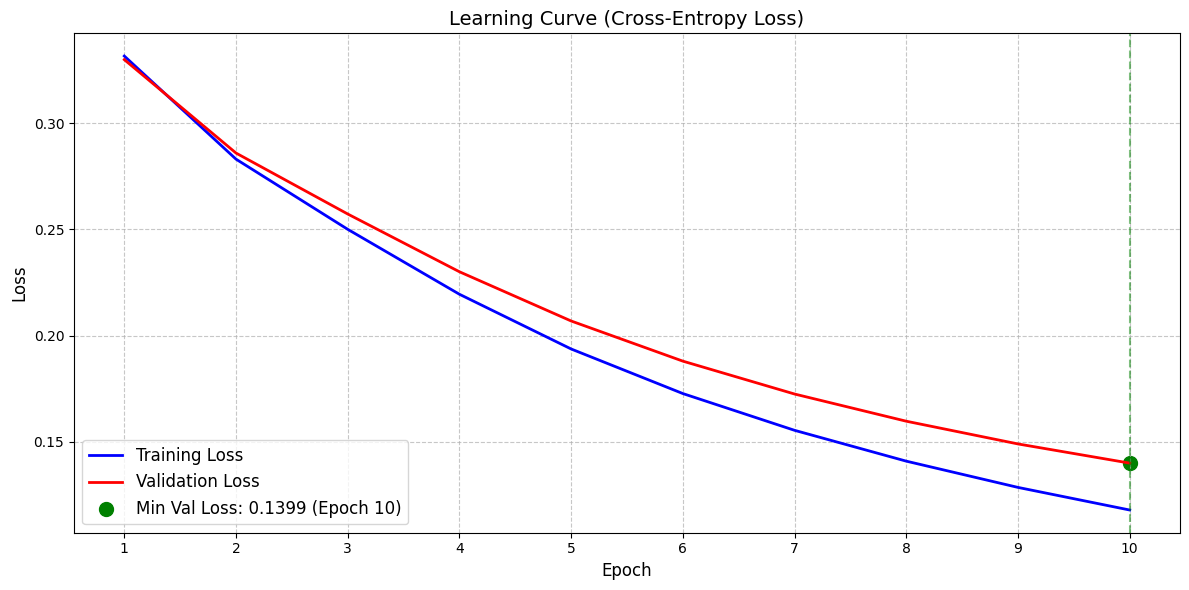


Training Summary:
Final Training Loss: 0.1178
Minimum Validation Loss: 0.1399 at Epoch 10
Final Validation Loss: 0.1399

Overfitting Indicator:
Final Train-Val Loss Gap: -0.0221
Model may be underfitting (training loss > validation loss)


In [ ]:



plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.plot(nn.loss_train, label='Training Loss', color='blue', linewidth=2)
plt.plot(nn.loss_val, label='Validation Loss', color='red', linewidth=2)

#markers for minimum validation loss
min_val_loss = min(nn.loss_val)
min_val_epoch = nn.loss_val.index(min_val_loss)
plt.scatter(min_val_epoch, min_val_loss, color='green', s=100, 
            label=f'Min Val Loss: {min_val_loss:.4f} (Epoch {min_val_epoch+1})')

#
plt.title('Learning Curve (Cross-Entropy Loss)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(len(nn.loss_train)), range(1, len(nn.loss_train)+1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# 
plt.axvline(x=min_val_epoch, color='green', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 
print("\nTraining Summary:")
print(f"Final Training Loss: {nn.loss_train[-1]:.4f}")
print(f"Minimum Validation Loss: {min_val_loss:.4f} at Epoch {min_val_epoch+1}")
print(f"Final Validation Loss: {nn.loss_val[-1]:.4f}")

#
final_gap = nn.loss_train[-1] - nn.loss_val[-1]
print(f"\nOverfitting Indicator:")
print(f"Final Train-Val Loss Gap: {final_gap:.4f}")
if final_gap < 0:
    print("Model may be underfitting (training loss > validation loss)")
elif final_gap < 0.1:
    print("Good generalization (small gap between train and val loss)")
else:
    print("Potential overfitting (large gap between train and val loss)")

c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10, Train Loss: 0.3292
Epoch 2/10, Train Loss: 0.2709
Epoch 3/10, Train Loss: 0.2409
Epoch 4/10, Train Loss: 0.1998
Epoch 5/10, Train Loss: 0.1699
Epoch 6/10, Train Loss: 0.1463
Epoch 7/10, Train Loss: 0.1308
Epoch 8/10, Train Loss: 0.1169
Epoch 9/10, Train Loss: 0.1046
Epoch 10/10, Train Loss: 0.0964


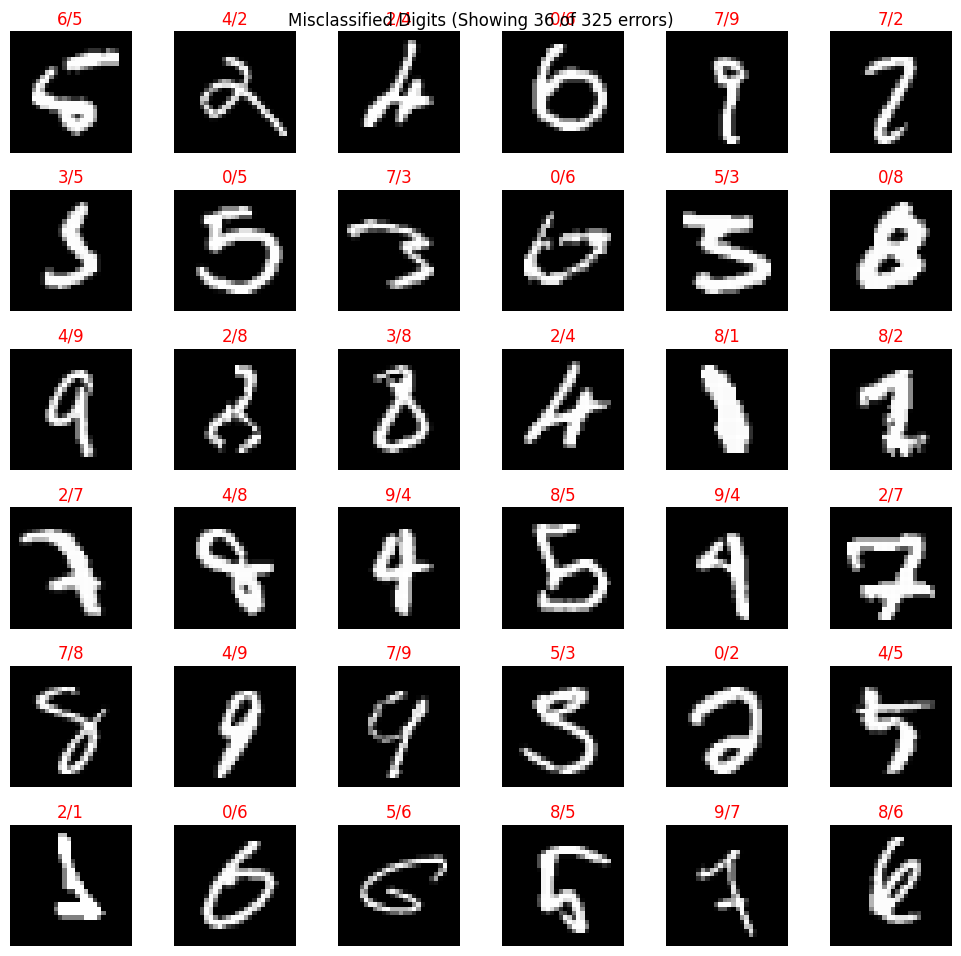


Error Analysis:
Total samples: 10000
Misclassified: 325
Error rate: 3.25%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

class NeuralNetwork:
    def __init__(self, n_nodes1=400, n_output=10, sigma=0.01, 
                 epochs=10, batch_size=20, lr=0.1, verbose=True):
        """
        Initialize the neural network
        
        Parameters:
        -----------
        n_nodes1 : int (default=400)
            Number of nodes in hidden layer
        n_output : int (default=10)
            Number of output nodes
        sigma : float (default=0.01)
            Standard deviation for weight initialization
        epochs : int (default=10)
            Number of training epochs
        batch_size : int (default=20)
            Mini-batch size
        lr : float (default=0.1)
            Learning rate
        verbose : bool (default=True)
            Whether to print training progress
        """
        self.n_nodes1 = n_nodes1
        self.n_output = n_output
        self.sigma = sigma
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.verbose = verbose
        self.loss_train = []
        self.loss_val = []
    
    def _init_weights(self, n_features):
        """Initialize weights and biases"""
        self.W1 = self.sigma * np.random.randn(n_features, self.n_nodes1)
        self.b1 = np.zeros(self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_output)
        self.b2 = np.zeros(self.n_output)
    
    def _sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))
    
    def _softmax(self, x):
        """Softmax function"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def _cross_entropy_loss(self, y_pred, y_true):
        """Cross entropy loss with numerical stability"""
        delta = 1e-7
        return -np.sum(y_true * np.log(y_pred + delta)) / len(y_pred)
    
    def forward_propagation(self, X):
        """Forward pass through the network"""
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._softmax(self.z2)
        return self.a2
    
    def backward_propagation(self, X, y, y_pred):
        """Backward pass to compute gradients"""
        m = len(X)
        dz2 = (y_pred - y) / m
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0)
        dz1 = np.dot(dz2, self.W2.T) * (self.a1 * (1 - self.a1))
        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0)
        return dW1, db1, dW2, db2
    
    def fit(self, X, y, X_val=None, y_val=None):
        """Train the network"""
        n_features = X.shape[1]
        self._init_weights(n_features)
        
        for epoch in range(self.epochs):
            # Mini-batch training
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # Forward and backward pass
                y_pred = self.forward_propagation(X_batch)
                dW1, db1, dW2, db2 = self.backward_propagation(X_batch, y_batch, y_pred)
                
                # Update weights
                self.W1 -= self.lr * dW1
                self.b1 -= self.lr * db1
                self.W2 -= self.lr * dW2
                self.b2 -= self.lr * db2
            
            # Calculate losses
            train_pred = self.forward_propagation(X)
            train_loss = self._cross_entropy_loss(train_pred, y)
            self.loss_train.append(train_loss)
            
            if X_val is not None and y_val is not None:
                val_pred = self.forward_propagation(X_val)
                val_loss = self._cross_entropy_loss(val_pred, y_val)
                self.loss_val.append(val_loss)
            
            if self.verbose:
                if X_val is not None and y_val is not None:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}")
    
    def predict_classes(self, X):
        """Predict class labels"""
        probabilities = self.forward_propagation(X)
        return np.argmax(probabilities, axis=1)

def display_misclassified(y_pred, y_true, X_data, num=36):
    """Display misclassified images with predicted/true labels"""
    incorrect = np.where(y_pred != y_true)[0]
    if len(incorrect) == 0:
        print("No misclassified samples found!")
        return
    
    num = min(num, len(incorrect))
    
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Misclassified Digits (Showing {num} of {len(incorrect)} errors)", y=0.95)
    
    for i, idx in enumerate(incorrect[:num]):
        ax = plt.subplot(int(np.ceil(num/6)), 6, i+1)
        ax.imshow(X_data[idx].reshape(28, 28), cmap='gray')
        ax.set_title(f"{y_pred[idx]}/{y_true[idx]}", color='red')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    error_rate = len(incorrect)/len(y_true)
    print(f"\nError Analysis:")
    print(f"Total samples: {len(y_true)}")
    print(f"Misclassified: {len(incorrect)}")
    print(f"Error rate: {error_rate:.2%}")

# MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784).astype(np.float64) / 255
X_test = X_test.reshape(-1, 784).astype(np.float64) / 255

# One-hot encode labels for training
enc = OneHotEncoder(sparse=False)
y_train_onehot = enc.fit_transform(y_train.reshape(-1, 1))

# Train the network
nn = NeuralNetwork(n_nodes1=400, epochs=10, batch_size=20, lr=0.1)
nn.fit(X_train, y_train_onehot)

# Predict on test set
y_pred = nn.predict_classes(X_test)

# Display misclassified examples
display_misclassified(y_pred, y_test, X_test, num=36)